In [1]:
import numpy as np
from DiscretizeTools import NormalDiscrete1, NormalDiscrete2, grow_grid
from linear import LinintGrow, LinintEqui
from scipy.optimize import root
import matplotlib.pyplot as plt
from ToolBox import SortOrder
from joblib import Parallel, delayed

In [8]:
class PortfolioChoice:
    def __init__(self, 
                 JR = 45, J = 80, NW = 7, NS = 7, NR = 7, NE = 1001, NA = 201, NX = 201,
                 γ = 0.1, β = 0.96, σζ = 0.0738, σϵ = 0.0106, σχ = 0.157**2, ρ = 0,
                 rf = 0.02, μr = 0.04, al = 0, au = 500, agrow = 0.04, Xgrow = 0.04, κ = 0.5, w = 1,
                 
                 ψ = np.array([1.00000, 0.99923, 0.99914, 0.99914, 0.99912, \
                0.99906, 0.99908, 0.99906, 0.99907, 0.99901, \
                0.99899, 0.99896, 0.99893, 0.99890, 0.99887, \
                0.99886, 0.99878, 0.99871, 0.99862, 0.99853, \
                0.99841, 0.99835, 0.99819, 0.99801, 0.99785, \
                0.99757, 0.99735, 0.99701, 0.99676, 0.99650, \
                0.99614, 0.99581, 0.99555, 0.99503, 0.99471, \
                0.99435, 0.99393, 0.99343, 0.99294, 0.99237, \
                0.99190, 0.99137, 0.99085, 0.99000, 0.98871, \
                0.98871, 0.98721, 0.98612, 0.98462, 0.98376, \
                0.98226, 0.98062, 0.97908, 0.97682, 0.97514, \
                0.97250, 0.96925, 0.96710, 0.96330, 0.95965, \
                0.95619, 0.95115, 0.94677, 0.93987, 0.93445, \
                0.92717, 0.91872, 0.91006, 0.90036, 0.88744, \
                0.87539, 0.85936, 0.84996, 0.82889, 0.81469, \
                0.79705, 0.78081, 0.76174, 0.74195, 0.72155, \
                0.00000]),
                 
                 eff = np.array([1.0000, 1.0719, 1.1438, 1.2158, 1.2842, 1.3527, \
                1.4212, 1.4897, 1.5582, 1.6267, 1.6952, 1.7217, \
                1.7438, 1.7748, 1.8014, 1.8279, 1.8545, 1.8810, \
                1.9075, 1.9341, 1.9606, 1.9623, 1.9640, 1.9658, \
                1.9675, 1.9692, 1.9709, 1.9726, 1.9743, 1.9760, \
                1.9777, 1.9700, 1.9623, 1.9546, 1.9469, 1.9392, \
                1.9315, 1.9238, 1.9161, 1.9084, 1.9007, 1.8354, \
                1.7701, 1.7048]),
                analytical = True):
        
        self.JR, self.J, self.NW, self.NS, self.NR, self.NE, self.NA, self.NX = JR, J, NW, NS, NR, NE, NA, NX
        self.γ, self.β, self.σζ, self.σϵ, self.σχ, self.ρ = γ, β, σζ, σϵ, σχ, ρ
        self.rf, self.μr, self.al, self.au, self.agrow, self.Xgrow, self.κ, self.w = rf, μr, al, au, agrow, Xgrow, κ, w 
        self.NSR = NS*NR
        self.egam = 1- 1/γ
        self.ana = analytical
        
        # surving probability and labor efficiency and pensions
        self.ψ = ψ
        self.eff = np.concatenate((eff, np.zeros(J - JR +1)))
        self.pen = np.concatenate((np.zeros(JR - 1), np.ones(J - JR + 1)*(κ*w*eff[-1])))
        
        # discretize zeta shocks
        ζ, self.πζ = NormalDiscrete1(NW,0,σζ)
        self.ζ = np.exp(ζ)
        
        # discretize eps-ctheta shocks
        temp, self.πsr = NormalDiscrete2(n = [NS, NR], sigma = [σϵ, σχ], rho = ρ)
        self.eps = np.exp(temp[:,0])
        self.χ = temp[:,1]
        
        # asset grid
        self.a = grow_grid(al, au, agrow, NA)   
        
        # endogenous lower and upper bound of cash-on-hand grid
        self.Xl = min(w*np.amin(eff[:JR-1])*np.amin(self.eps)*self.ζ[0], self.pen[JR-1])
        self.Xu = (1 + rf + μr + np.amax(self.χ))*au + w*np.amax(eff[:JR-1])*np.amax(self.eps)*ζ[-1]
        self.X = grow_grid(self.Xl, self.Xu, Xgrow, NX)
        
        self.aplus, self.c, self.V, self.Ω = self.policy()
        self.ΦX, self.ΦA = self.distribution()
        self.c_coh, self.y_coh, self.a_coh, self.o_coh, self.var_c, self.var_y, self.var_a, \
        self.var_o, self.cv_c, self.cv_a, self.cv_y, self.cv_o = self.aggregation()

        
    def policy(self):
        global RHS, Q
        print('Calculating Policy Functions...')
        margu = lambda x : max(x, 1e-10)**(-1/self.γ)
        aplus = np.zeros((self.J, self.NX))
        c = np.zeros((self.J, self.NX))
        V = np.zeros((self.J, self.NX))
        
        RHS = np.zeros((self.J, self.NA))
        Q = np.zeros((self.J, self.NA))
        
        
        def ValueFun(ap, cons, j):
            chelp = max(cons, 1e-10)
            il, ir, φ3 = LinintGrow(ap, self.al, self.au, self.agrow, self.NA)
            vf = 0
            if j < self.J - 1:
                vf = max(φ3*Q[j,il] + (1-φ3)*Q[j,ir], 1e-10)**self.egam/self.egam
            return chelp**self.egam/self.egam + self.β*self.ψ[j+1]*vf
        
        
        
        def SolvePortfolio(j, i):
            def FocPort(p):
                foc_port = 0
                if j + 1 >= self.JR - 1:
                    for sr in range(self.NSR):
                        Rport = 1 + self.rf + p*(self.μr + self.χ[sr])
                        Xp = Rport*self.a[i] + self.pen[j + 1]
                        ixl, ixr, φ0 = LinintGrow(Xp, self.Xl, self.Xu, self.Xgrow, self.NX)
                        dist = self.πsr[sr]
                        cp = φ0 * c[j+1, ixl] + (1-φ0)* c[j+1, ixr]
                        cp = max(cp, 1e-10)
                        foc_port += dist*(self.μr + self.χ[sr]) * self.a[i] * margu(cp)
                else:
                    for iw in range(self.NW):
                        for sr in range(self.NSR):
                            Rport = 1 + self.rf + p*(self.μr + self.χ[sr])
                            earnings = self.w * self.eff[j+1]*self.ζ[iw]
                            Xp = Rport*self.a[i]/self.eps[sr] + earnings
                            ixl, ixr, φ0 = LinintGrow(Xp, self.Xl, self.Xu, self.Xgrow, self.NX)
                            dist = self.πζ[iw] * self.πsr[sr]
                            cp = φ0 * c[j+1, ixl] + (1-φ0) * c[j+1,ixr]
                            cp = max(cp, 1e-10)
                            foc_port += dist*(self.μr + self.χ[sr])*self.a[i] * margu(self.eps[sr]*cp)
                return foc_port
            
            
            port0 = FocPort(0)
            port1 = FocPort(1)
            
            if port0 * port1 > 0:
                if abs(port0) > abs(port1):
                    Ωaux = 1
                else:
                    Ωaux = 0
            else:
                tol = 1e-5*abs(port0 - port1)
                tol = min(tol, 1e-8)
                
                res = root(FocPort, x0 = -port0/(port1 - port0), tol = tol)
                Ωaux = res.x[0]
            return Ωaux
        
        def ParaInt(i, age):
            j = age
            RHSaux = 0
            Qaux = 0
            if j >= self.JR - 1:
                for sr in range(self.NSR):
                    Rport = 1 + self.rf + Ω[j,i]*(self.μr + self.χ[sr])
                    Xp = Rport * self.a[i] + self.pen[j+1]
                    ixl, ixr, φ1 = LinintGrow(Xp, self.Xl, self.Xu, self.Xgrow, self.NX)
                    cp = max(φ1*c[j + 1, ixl] + (1-φ1)*c[j+1, ixr], 1e-10)
                    EV = φ1*(self.egam*V[j + 1, ixl])**(1/self.egam) + (1 - φ1)*(self.egam*V[j + 1, ixr])**(1/self.egam)
                    RHSaux += self.πsr[sr]*Rport*margu(cp)
                    Qaux += self.πsr[sr]*EV**self.egam/self.egam
            else:
                for iw in range(self.NW):
                    for sr in range(self.NSR):
                        Rport = 1 + self.rf + Ω[j,i]*(self.μr + self.χ[sr])
                        Xp = Rport * self.a[i]/self.eps[sr] + self.w*self.eff[j+1]*self.ζ[iw]
                        ixl, ixr, φ1 = LinintGrow(Xp, self.Xl, self.Xu, self.Xgrow, self.NX)
                        dist = self.πζ[iw] * self.πsr[sr]
                        cp = max(φ1*c[j+1, ixl] + (1-φ1)*c[j+1, ixr], 1e-10)
                        EV = φ1*(self.egam*V[j + 1, ixl])**(1/self.egam) + (1 - φ1)*(self.egam*V[j + 1, ixr])**(1/self.egam)
                        RHSaux += dist*Rport*margu(self.eps[sr]*cp)
                        Qaux += dist*(self.eps[sr]*EV)**self.egam/self.egam
            RHSaux = (self.β*self.ψ[j+1]*RHSaux)**(-self.γ)
            Qaux = (self.egam*Qaux)**(1/self.egam)  
            return RHSaux, Qaux
        
        def interpolate(j):
            global RHS, Q
            
            RHS[j, :] = 0
            Q[j, :] = 0
            
            results = Parallel(n_jobs=8)(delayed(ParaInt)(i, age =j) for i in range(self.NA))
            for i in range(self.NA):
                RHS[j,i] = results[i][0]
                Q[j,i] = results[i][1]

        def SolveConsumption(j, x):
            global cons_com
            def FocCons(ap):
                global cons_com
                cons_com = self.X[x] - ap
                il, ir, φ2 = LinintGrow(ap, self.al, self.au, self.agrow, self.NA)
                foc_cons = cons_com - φ2*RHS[j, il] - (1-φ2)*RHS[j, ir]
                return foc_cons
            
            if self.X[x] < 1e-10:
                apaux = 0
                caux = 0
                Vaux = ValueFun(0,0,j)
            else:
                apaux = root(FocCons, x0 = aplus[j+1, x]).x[0]
                if apaux < 0:
                    apaux = 0
                    caux = self.X[x]
                else:
                    caux = cons_com
                Vaux = ValueFun(apaux, caux, j)
            
            return apaux, caux, Vaux
        
        
        Ω = np.zeros((self.J, self.NA))
        for x in range(self.NX):
            aplus[-1, x] = 0
            c[-1, x] = self.X[x]
            V[-1, x] = ValueFun(0, c[-1, x], self.J-1)
        
        def ParaPort(i, age):
            j = age
            Ωaux = SolvePortfolio(j, i)
            return Ωaux
        def ParaCon(x, age):
            j = age
            aaux, caux, Vaux = SolveConsumption(j, x)
            return aaux, caux, Vaux
        
        for j in range(self.J - 2, -1, -1):
            if j%10 == 0:
                print(j)
            results = Parallel(n_jobs=8)(delayed(ParaPort)(i, age = j) for i in range(1, self.NA))
            for i in range(1, self.NA):
                Ω[j,i] = results[i-1]
            
            Ω[j,0] = Ω[j,1]
            
            interpolate(j)
            
            results = Parallel(n_jobs=8)(delayed(ParaCon)(x, age = j) for x in range(self.NX))
            for x in range(self.NX):
                aplus[j,x] = results[x][0]
                c[j,x] = results[x][1]
                V[j,x] = results[x][2]
                
        return aplus, c, V, Ω

    def distribution(self):
        print('Calculating Distribution Functions...')
        global ΦX, ΦA
        ΦX = np.zeros((self.J, self.NX))
        ΦA = np.zeros((self.J, self.NA))
        
        def distributionX(j):
            global ΦX
            if j == 0:
                for iw in range(self.NW):
                    Xp = self.w*self.eff[0]*self.ζ[iw]
                    
                    ixl, ixr, φ4 = LinintGrow(Xp, self.Xl, self.Xu, self.Xgrow, self.NX)
                    
                    ΦX[0,ixl] += self.πζ[iw]*φ4
                    ΦX[0,ixr] += self.πζ[iw]*(1-φ4)
            elif j <= self.JR - 2:
                for i in range(self.NA):
                    for iw in range(self.NW):
                        for sr in range(self.NSR):
                            Rport = 1 + self.rf + self.Ω[j-1, i]*(self.μr + self.χ[sr])
                            Xp = Rport*self.a[i]/self.eps[sr] + self.w*self.eff[j]*self.ζ[iw]
                            
                            ixl, ixr, φ4 = LinintGrow(Xp, self.Xl, self.Xu, self.Xgrow, self.NX)
                            
                            dist = self.πζ[iw]*self.πsr[sr]
                            ΦX[j,ixl] += dist*φ4*ΦA[j-1, i]
                            ΦX[j,ixr] += dist*(1-φ4)*ΦA[j-1, i]
                            
            else:
                for i in range(self.NA):
                    for sr in range(self.NSR):
                        Rport = 1 + self.rf + self.Ω[j-1, i]*(self.μr + self.χ[sr])
                        Xp = Rport*self.a[i] + self.pen[j]
                        
                        ixl, ixr, φ4 = LinintGrow(Xp, self.Xl, self.Xu, self.Xgrow, self.NX)
                            
                        ΦX[j,ixl] += self.πsr[sr]*φ4*ΦA[j-1, i]
                        ΦX[j,ixr] += self.πsr[sr]*(1-φ4)*ΦA[j-1, i]
        
        
        def distributionA(j):
            global ΦA
            for x in range(self.NX):
                il, ir, φ5 = LinintGrow(self.aplus[j,x], self.al, self.au, self.agrow, self.NA)
                il = min(il, self.NA)
                ir = min(ir, self.NA)
                φ5 = min(φ5, 1)
                ΦA[j,il] += φ5*ΦX[j,x]
                ΦA[j,ir] += (1-φ5)*ΦX[j,x]
        
        for j in range(self.J):
            if j%10 == 0:
                print(j)
            distributionX(j)
            distributionA(j)
        
        return ΦX, ΦA
    


    def aggregation(self):
        print('Calculating Aggregations...')
        
        def GenerateEta():
            ηl = np.zeros(self.J)
            ηu = np.zeros(self.J)
            η = np.zeros((self.J, self.NE))
            
            for j in range(1,self.JR - 1):
                ηl[j] = j*np.amin(np.log(self.eps))
                ηu[j] = j*np.amax(np.log(self.eps))
                η[j,:] = np.linspace(ηl[j], ηu[j], self.NE)
                
            for j in range(self.JR-1, self.J):
                ηl[j] = ηl[self.JR - 2]
                ηu[j] = ηu[self.JR - 2]
                η[j,:] = η[self.JR-2,:]
            ΦE = np.zeros((self.J, self.NE))
            ΦE[0,:] = 1/self.NE
            
            for j in range(1, self.JR - 1):
                for e in range(self.NE):
                    for sr in range(self.NSR):
                        ηaux = η[j-1, e] + np.log(self.eps[sr])
                        el, er, φ6 = LinintEqui(ηaux, ηl[j], ηu[j], self.NE)
                        ΦE[j,el] += self.πsr[sr]*φ6*ΦE[j-1, e]
                        ΦE[j,er] += self.πsr[sr]*(1-φ6)*ΦE[j-1, e]

        
            for j in range(self.JR-1, self.J):
                ΦE[j,:] = ΦE[self.JR-2,:]
            
            η = np.exp(η)
            
            return η, ΦE
    
        if not self.ana: η, ΦE = GenerateEta()

            
        c_coh = np.zeros(self.J)
        y_coh = np.zeros(self.J)
        a_coh = np.zeros(self.J)
        o_coh = np.zeros(self.J)

        if self.ana:
            for j in range(self.J):
                for iw in range(self.NW):
                    y_coh[j] += (self.w*self.eff[j]*self.ζ[iw] + self.pen[j]) * self.πζ[iw]
                
                for x in range(self.NX):
                    c_coh[j] += self.c[j, x]*self.ΦX[j,x]
                
                if j > 0:
                    for i in range(self.NA):
                        a_coh[j] += self.a[i]*ΦA[j-1,i]
                        o_coh[j] += self.Ω[j-1, i]*ΦA[j-1,i]
                        
        else:
            for j in range(self.J):
                for e in range(self.NE):
                    for iw in range(self.NW):
                        y_coh[j] += (self.w*self.eff[j]*self.ζ[iw] + self.pen[j])*η[j,e]*self.πζ[iw]*ΦE[j,e]
                    for x in range(self.NX):
                        c_coh[j] += self.c[j,x]*η[j,e]*ΦX[j,x]*ΦE[j,e]
                        
                    if j > 0:
                        for i in range(self.NA):
                            a_coh[j] += self.a[i]*η[j,e]*ΦA[j-1,i]*ΦE[j,e]
                            o_coh[j] += self.Ω[j-1, i]*ΦA[j-1,i]*ΦE[j,e]
        
        var_c = np.zeros(self.J)
        var_y = np.zeros(self.J)
        var_a = np.zeros(self.J)
        var_o = np.zeros(self.J)
        
        if self.ana:
            for j in range(self.J):
                for iw in range(self.NW):
                    var_y[j] += (self.w * self.eff[j]* self.ζ[iw] + self.pen[j])**2*self.πζ[iw]
                for x in range(self.NX):
                    var_c[j] += self.c[j,x]**2*ΦX[j,x]
                
                for i in range(self.NA):
                    if j > 0:
                        var_a[j] += self.a[i]**2*ΦA[j-1, i]
                        var_o[j] += self.Ω[j-1, i]**2*ΦA[j-1, i]
        else:
            for j in range(self.J):
                for e in range(self.NE):
                    for iw in range(self.NW):
                        var_y[j] += ((self.w * self.eff[j]* self.ζ[iw] + self.pen[j])*η[j,e])**2*self.πζ[iw]*ΦE[j,e]
                    for x in range(self.NX):
                        var_c[j]+= (self.c[j,x]*η[j,e])**2*ΦX[j,x]*ΦE[j,e]
                    
                    if j > 0:
                        for i in range(self.NA):
                            var_a[j] += (self.a[i]*η[j,e])**2*ΦA[j-1, i]*ΦE[j,e]
                            var_o[j] += self.Ω[j-1, i]**2*ΦA[j-1, i]*ΦE[j,e]
                    
        
        var_c += -c_coh**2
        var_y += -y_coh**2
        var_a += -a_coh**2
        var_o += -o_coh**2
        
        if self.ana:
            ση = self.σϵ*np.array([min(j, self.JR-2) for j in range(self.J)])
            μexp = np.exp(0.5*ση)
            σexp = np.exp(ση)*(np.exp(ση) - 1)
            
            var_y = μexp**2*var_y + σexp*y_coh**2 + σexp*var_y
            var_c = μexp**2*var_c + σexp*c_coh**2 + σexp*var_c
            var_a = μexp**2*var_a + σexp*a_coh**2 + σexp*var_a
            
            y_coh = μexp*y_coh
            c_coh = μexp*c_coh
            a_coh = μexp*a_coh
        
        cv_y = np.zeros(self.J)
        cv_c = np.zeros(self.J)
        cv_a = np.zeros(self.J)
        cv_o = np.zeros(self.J)
        
        cv_y = np.maximum(var_y, 0)**0.5/np.maximum(y_coh, 1e-10)
        cv_c = np.maximum(var_c, 0)**0.5/np.maximum(c_coh, 1e-10)
        cv_a = np.maximum(var_a, 0)**0.5/np.maximum(a_coh, 1e-10)
        cv_o = np.maximum(var_o, 0)**0.5/np.maximum(o_coh, 1e-10)
        
        if not self.ana:
            thresholds = np.array([0.05, 0.25, 0.5, 0.75, 0.95])
            
            quantiles = np.zeros((len(thresholds),self.J))
            
            def ParaAna(j):
                quant = np.zeros(len(thresholds))
                
                a_sort = np.zeros(self.NA * self.NE)
                a_dist = np.zeros(self.NA * self.NE)
                a_cdist = np.zeros(self.NA * self.NE)

                ic = 1
                for e in range(self.NE):
                    for ia in range(self.NA):
                        if ΦA[j-1, ia]*ΦE[j, e] > 1e-12:
                            a_sort[ic-1] = self.a[ia]*η[j,e]
                            a_dist[ic-1] = ΦA[j-1, ia]*ΦE[j, e]
                            ic += 1
                            
                NC = ic - 1
                a_sort, iorder = SortOrder(a_sort[:NC])
                a_cdist[0] = a_dist[iorder[0]]

                for ic in range(1, NC):
                    a_cdist[ic] = a_cdist[ic-1] + a_dist[iorder[ic]]

                for t in range(len(thresholds)):
                    if thresholds[t] <= a_cdist[0]:
                        quant[t] = a_sort[0]
                    else:
                        for ic in range(1, NC):
                            if thresholds[t] < a_cdist[ic]:
                                slope = (a_sort[ic] - a_sort[ic-1])/(a_cdist[ic] - a_cdist[ic-1])
                                quant[t] = a_sort[ic-1] + slope*(thresholds[t] - a_cdist[ic-1])
                                break
                            elif ic == NC-1:
                                quant[t] = a_sort[NC-1]    
                return quant
            
            results = Parallel(n_jobs=8)(delayed(ParaAna)(j) for j in range(1, self.J))
            
            for j in range(1, self.J):
                quantiles[:,j] = results[j-1]
            
                
            ages = np.arange(self.J) + 21
            
            fig, ax = plt.subplots(1,figsize = (10,10))
            
            ax.plot(ages, quantiles[0,:], linestyle = 'dashed', label='q(0.05)')
            ax.plot(ages, quantiles[1,:], label='q(0.25)')             
            ax.plot(ages, quantiles[2,:], label='q(0.50)')
            ax.plot(ages, quantiles[3,:], label='q(0.75)')
            ax.plot(ages, quantiles[4,:], linestyle = 'dashdot', label='q(0.95)')
            ax.legend()
            ax.set_xlabel('Agej')
            ax.set_ylabel('Total asset aj')
            ax.axvline(x = self.JR + 20, c = 'k', linestyle = '--', linewidth = 2)
            
        
        return c_coh, y_coh, a_coh, o_coh, var_c, var_y, var_a, var_o, cv_c, cv_a, cv_y, cv_o
        


In [3]:
%time model1 = PortfolioChoice()

Calculating Policy Functions...
70
60
50
40
30
20
10
0
Calculating Distribution Functions...
0
10
20
30
40
50
60
70
Calculating Aggregations...
Wall time: 2min 43s


In [4]:
%time model2 = PortfolioChoice(ρ = 0.25)

Calculating Policy Functions...
70
60
50
40
30
20
10
0
Calculating Distribution Functions...
0
10
20
30
40
50
60
70
Calculating Aggregations...
Wall time: 3min 34s


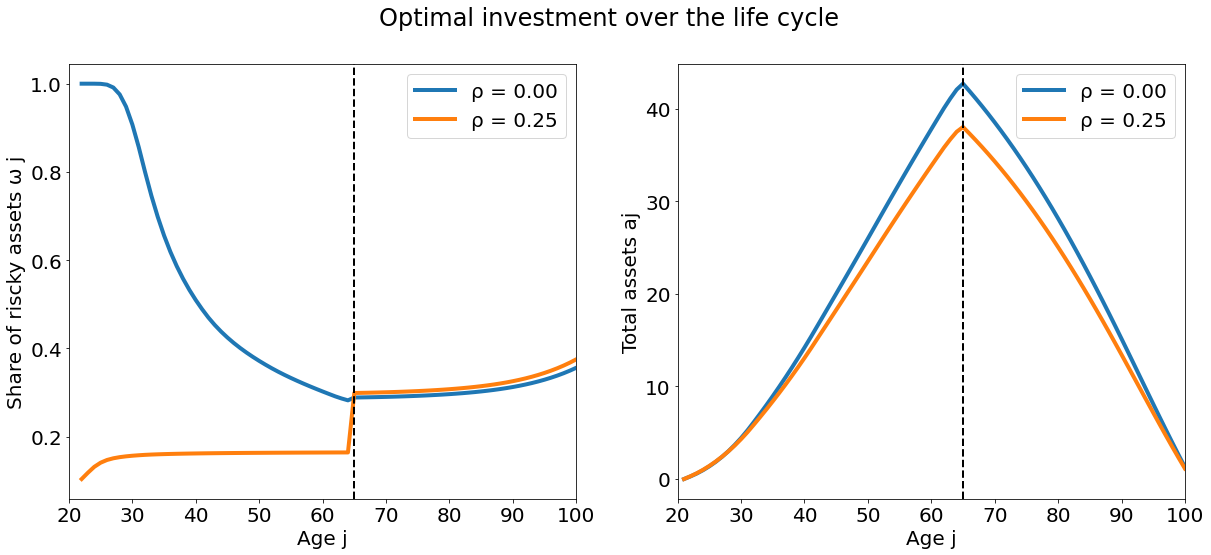

In [5]:
plt.rcParams['lines.linewidth'] = '4'
plt.rcParams.update({'font.size': 20})


ages = np.arange(model1.J) + 21

fig, ax = plt.subplots(1,2,figsize = (20,8))
fig.suptitle('Optimal investment over the life cycle')


ax[0].plot(ages[1:],model1.o_coh[1:], label = 'ρ = 0.00')     
ax[0].plot(ages[1:],model2.o_coh[1:], label = 'ρ = 0.25')     
# ax[0].set_ylim(0,1.01)


ax[1].plot(ages, model1.a_coh, label = 'ρ = 0.00')
ax[1].plot(ages, model2.a_coh, label = 'ρ = 0.25')
# ax[1].set_ylim(0,50)


label = ['Share of riscky assets ω j', 'Total assets aj']
for i in range(2):
    ax[i].set_xlim(20,100)
    ax[i].legend()
    ax[i].set_xlabel('Age j')
    ax[i].set_ylabel(label[i])
    ax[i].axvline(x = model1.JR + 20, c = 'k', linestyle = '--', linewidth = '2')


Calculating Policy Functions...
70
60
50
40
30
20
10
0
Calculating Distribution Functions...
0
10
20
30
40
50
60
70
Calculating Aggregations...
Wall time: 5min 5s


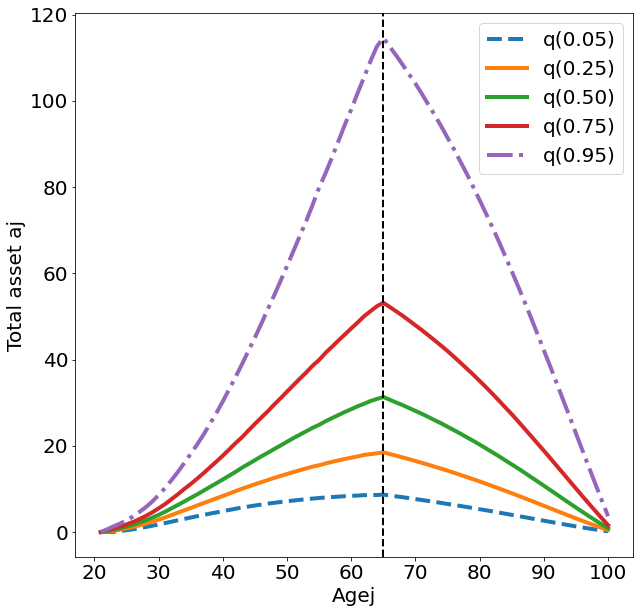

In [6]:
%time model3 = PortfolioChoice(analytical=False)